# *Yellow is the new black*
------

## Abstract
The creation and propagation of false information has existed since the dawn of time.
Behind these misleading elements are often hidden political or financial intentions, in order to gain credit or make competitors lose it.
With the advent of the Internet and the ever faster and more direct flow of information, it is becoming easier every day to deceive your fellow citizens and to be fooled.
The term *fake news* took on a new dimension during the 2016 American presidential election, when Donald Trump used it extensively to describe the media coverage about himself. In this instantaneous era, it becomes crucial to be able to be critical of the information received. With this work, we want to highlight the risks related to the propagation of false information by using the fakes news themselves, from the Liar database. The power that these fake new vehicles hold is mostly in the use and resonance we make of them. Our credulity becomes credibility, it's up to us to turn the equation the other way around!

------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import urllib
from urllib.request import Request, urlopen
import json
from bs4 import BeautifulSoup
from PIL import Image

<div class="alert alert-block alert-info"><b>Tip: </b> Use blue boxes for Tips and notes. If it’s a note, you don’t have to include the word “Note”. </div>

------

## Data Loading and Cleaning

In [2]:
datapath = 'data/liar_dataset/'

The files are simple *tsv* which is similar to *csv* with tabs instead of comma. All the columns names are known from the `README` files that accompagne the data

In [3]:
columns = ['ID', 
           'Label', 
           'Statement', 
           'Subject', 
           'Speaker', 
           'Job title', 
           'Home State', 
           'Party Affiliations', 
           'Barely True Counts', 
           'False Counts', 
           'Half True Counts', 
           'Mostly True Counts', 
           'Pants on Fire Counts', 
           'Context']
liar_df = pd.read_csv(datapath + 'train.tsv',delimiter='\t',encoding='utf-8', names = columns)

* Column 1: the ID of the statement ([ID].json).
* Column 2: the label.
* Column 3: the statement.
* Column 4: the subject(s).
* Column 5: the speaker.
* Column 6: the speaker's job title.
* Column 7: the state info.
* Column 8: the party affiliation.
* Column 9-13: the total credit history count, including the current statement.
    * 9: barely true counts.
    * 10: false counts.
    * 11: half true counts.
    * 12: mostly true counts.
    * 13: pants on fire counts.
* Column 14: the context (venue / location of the speech or statement).

In [4]:
liar_df.head()

,ID,Label,Statement,Subject,Speaker,Job title,Home State,Party Affiliations,Barely True Counts,False Counts,Half True Counts,Mostly True Counts,Pants on Fire Counts,Context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


This function allows to extract additionnal information from the politifact website by downloading the json source file and returning the json structure parsed.

In [5]:
def get_additional_info(ID):
    idx =  re.search("[0-9]*", ID)
    req = Request('http://www.politifact.com//api/v/2/statement/'+idx.group()+'/?format=json', headers={'User-Agent': 'Mozilla/5.0'})
    response = urllib.request.urlopen(req, timeout=10).read().decode('utf-8')
    a = json.loads(response)
    return a

In [6]:
print(BeautifulSoup(get_additional_info("1123.json")['statement'], 'html.parser').prettify())
#get_additional_info("1123.json")['statement_date']

<p>
 Health care reform legislation is “likely to mandate free ‘sex change’ surgeries.”
</p>


In [8]:
liar_df['Date'] = pd.Series(np.zeros(len(liar_df)), index=liar_df.index)

In [ ]:
for i in range(0,len(liar_df)):
    liar_df.loc[i,'Date'] = get_additional_info(liar_df.loc[i,'ID'])['statement_date']

In [10]:
liar_df['Date'] = pd.to_datetime(liar_df['Date'])

------

All of the result and interpretation we can have from this dataset are conditionned on it. More precisely, the dataset has been constructed from differents sources of media. This selection can be biased. To lower the impact of this bias, the authors have make sure to balance the numbers of article extrated between the two american political parties. But this balance can or cannot represent the reality. It can be interesting to check it the sampling can be considered as representative or not.

In [8]:
lie = liar_df[liar_df['Label'] == 'false']

## Determine which are the main subjects falsely propagated in the United States.

In [9]:
liar_df['Label'].unique()

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

In [33]:
col = "Subject"
df = liar_df[[col, "ID", "Label"]]
df.columns = [col, "Count", "Label"]
col_subject = df.groupby([col, "Label"]).count()[["Count"]]
col_subject = col_subject.unstack('Label')
col_subject = col_subject.fillna(0)
col_subject = col_subject.sort_values(by=[('Count', 'false')], ascending = False)
col_subject = col_subject[[('Count', 'false'), ('Count', 'pants-fire'), ('Count', 'barely-true'),('Count', 'half-true'),('Count', 'mostly-true'),('Count', 'true')]]
col_subject.head(10)

Count                                                   
Label                false pants-fire barely-true half-true mostly-true  true
Subject                                                                      
health-care           95.0       37.0        66.0      76.0        51.0  56.0
taxes                 53.0       21.0        50.0      68.0        63.0  53.0
immigration           53.0       25.0        42.0      58.0        53.0  22.0
elections             52.0       30.0        32.0      36.0        44.0  58.0
education             34.0        9.0        34.0      52.0        63.0  45.0
candidates-biography  33.0       26.0        39.0      22.0        32.0  38.0
economy               24.0        3.0        24.0      30.0        23.0  33.0
jobs                  22.0        4.0        10.0      23.0        22.0  17.0
foreign-policy        21.0        9.0        12.0      19.0        15.0   9.0
abortion              21.0        7.0        14.0      18.0        14.0  18.0

In [34]:
col_subject = col_subject.head(5)
col_subject

Count                                                   
Label       false pants-fire barely-true half-true mostly-true  true
Subject                                                             
health-care  95.0       37.0        66.0      76.0        51.0  56.0
taxes        53.0       21.0        50.0      68.0        63.0  53.0
immigration  53.0       25.0        42.0      58.0        53.0  22.0
elections    52.0       30.0        32.0      36.0        44.0  58.0
education    34.0        9.0        34.0      52.0        63.0  45.0

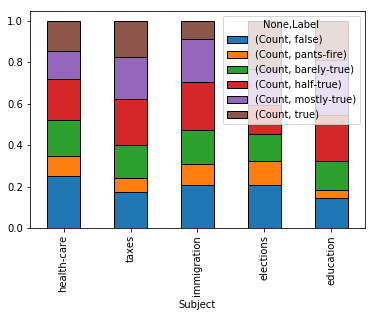

In [35]:
normalized_col_subject = col_subject.div(col_subject.sum(axis = 1),axis = 'index')
normalized_col_subject.plot(kind='bar', stacked=True, ec='black')

## What are the preferred formats for which topics?

### What are the preferred context to lie?

In [42]:
col = "Context"
df = liar_df[[col, "ID", "Label"]]
df.columns = [col, "Count", "Label"]
col_subject = df.groupby([col, "Label"]).count()[["Count"]]
col_subject = col_subject.unstack('Label')
col_subject = col_subject.fillna(0)
col_subject = col_subject[[('Count', 'false'), ('Count', 'pants-fire'), ('Count', 'barely-true'),('Count', 'half-true'),('Count', 'mostly-true'),('Count', 'true')]]
col_subject = col_subject.div(col_subject.sum(axis = 1),axis = 'index')
col_subject = col_subject.sort_values(by=[('Count', 'false')], ascending = False)
col_subject = col_subject
col_subject

Count             \
Label                                              false pants-fire   
Context                                                               
 CNN's 'The Situation Room'                          1.0        0.0   
her book, 'Going Rogue'                              1.0        0.0   
a campaign stop in Exeter, N.H                       1.0        0.0   
a campaign stop in New Hampshire                     1.0        0.0   
an interview on CNN’s “Piers Morgan Tonight”         1.0        0.0   
an interview on CNN’s “State of the Union”           1.0        0.0   
his book <i>The Obama Nation</i>.                    1.0        0.0   
his book "A More Perfect Union"                      1.0        0.0   
a campaign-style ad.                                 1.0        0.0   
a speech in North Carolina                           1.0        0.0   
a candidate forum                                    1.0        0.0   
a speech in New York                                 1.0        0.0   
a candidates forum in Dunedin                        1.0        0.0   
his State of the State speech                        1.0        0.0   
a ceremony to introduce new local transit autho...   1.0        0.0   
a chain e-mail circulated on the Internet            1.0        0.0   
a chain e-mail sent to many people.                  1.0        0.0   
his MSNBC "Countdown" program                        1.0        0.0   
a chain email apparently focused on Wisconsin c...   1.0        0.0   
his Fox News show                                    1.0        0.0   
his Fox News Channel show                            1.0        0.0   
a column by the Texas Republican on the Web sit...   1.0        0.0   
a column in Human Events.                            1.0        0.0   
a column in Investor's Business Daily.               1.0        0.0   
a column in TownHall.com                             1.0        0.0   
an interview on Fox News with Bill O'Reilly          1.0        0.0   
her campaign website                                 1.0        0.0   
an interview on Fox News' "America's Newsroom"       1.0        0.0   
her book, Going Rogue                                1.0        0.0   
a campaign stop in Concord, N.H.                     1.0        0.0   
...                                                  ...        ...   
a roundtable section of the HBO show "Real Time...   0.0        0.0   
a response to a question after a town hall meeting   0.0        0.0   
a report on his past accomplishments as Tampa m...   0.0        0.0   
a rally in Cincinnati                                0.0        0.0   
a rally in Tempe, Ariz.                              0.0        0.0   
a rally in Cincinnati, Ohio                          0.0        0.0   
a rally in Columbus, Ohio                            0.0        0.0   
a rally in Florida                                   0.0        0.5   
a rally in Fountain Hills, Ariz.                     0.0        1.0   
a rally in Hershey, Pa.                              0.0        1.0   
a rally in New Hampshire                             0.0        0.0   
a rally in North Carolina                            0.0        0.0   
a rally in Portland, Maine                           0.0        0.0   
a rally in Sacramento, Calif.                        0.0        0.0   
a rally in Tampa                                     0.0        0.0   
a rally in Tampa, Fla.                               0.0        0.0   
a rally speech                                       0.0        1.0   
a report on ABC News' "This Week with Christian...   0.0        0.0   
a rally.                                             0.0        0.0   
a rebuttal to the State of the Union address         0.0        0.0   
a recall debate                                      0.0        0.0   
a recent report                                      0.0        0.0   
a recorded message                                   0.0        0.0   
a re

## What are the most prominent professions among the liars?

### What are the most prominent professions in the dataset ?

In [10]:
jobs = liar_df.groupby("Job title").count()
jobs = jobs.sort_values(by=['ID'], ascending = False)
jobs = jobs[["ID"]]
jobs.head()

,ID
Job title,
President,492
U.S. Senator,479
Governor,391
President-Elect,273
U.S. senator,263


### Among the liars ??

For each Statement, we can access the job title of the speaker. That way, we can access the most frequent jobs in the liar groups for this specific dataset.

In [33]:
jobs_lie = lie.groupby("Job title").count()
jobs_lie = jobs_lie[["ID"]]
jobs_lie.shape

(403, 1)

In [34]:
jobs_lie = jobs_lie.sort_values(by=['ID'], ascending = False)
jobs_lie.head()

,ID
Job title,
President-Elect,101
Governor,75
President,68
U.S. Senator,66
U.S. senator,51


Because all the jobs don't have the same media coverage, it is more interesting to have the percentage of lie of the job than the raw numbers themselves

In [35]:
jobs_lie = jobs_lie.join(jobs, lsuffix = '_lie', rsuffix = '_total')

In [36]:
jobs_lie["ratio (%)"] =jobs_lie["ID_lie"]/jobs_lie["ID_total"]*100

In [42]:
jobs_lie.sort_values(by=['ID_total'], ascending = False)

,ID_lie,ID_total,ratio (%)
Job title,,,
President,68,492,13.821138
U.S. Senator,66,479,13.778706
Governor,75,391,19.181586
President-Elect,101,273,36.996337
U.S. senator,51,263,19.391635
Presidential candidate,29,254,11.417323
Former governor,28,176,15.909091
U.S. Representative,27,172,15.697674
Milwaukee County Executive,35,149,23.489933


### Lie in politics

The people that have a political message generaly have a party affiliation.

In [26]:
lie_party = lie[lie['Party Affiliations'] != 'none']
lie_party = lie_no_party.groupby("Job title").count()
lie_party = lie_no_party[["ID"]].sort_values(by=['ID'], ascending = False)
lie_party.head()

,ID
Job title,
President-Elect,101
Governor,75
President,68
U.S. Senator,66
U.S. senator,51


In [41]:
politics_regex = re.compile(r'\b(mayor|president|council|house|candidate|political|assembly|republican|governor|senator)[s]*\b' ,re.I)
politics_liar_sets = jobs_lie[jobs_lie.index.str.contains(politics_regex, regex=True) == True]
politics_liar_sets

/Users/Moi/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app


,ID_lie,ID_total,ratio (%)
Job title,,,
President-Elect,101,273,36.996337
Governor,75,391,19.181586
President,68,492,13.821138
U.S. Senator,66,479,13.778706
U.S. senator,51,263,19.391635
Senator,33,147,22.448980
Presidential candidate,29,254,11.417323
Former governor,28,176,15.909091
U.S. House of Representatives,27,102,26.470588


## Highlight which political parties tend to lie the most.

In [36]:
col = "Party Affiliations"
df = liar_df[[col, "ID", "Label"]]
df.columns = [col, "Count", "Label"]
col_subject = df.groupby([col, "Label"]).count()[["Count"]]
col_subject = col_subject.unstack('Label')
col_subject = col_subject.fillna(0)
col_subject = col_subject.sort_values(by=[('Count', 'false')], ascending = False)
col_subject = col_subject[[('Count', 'false'), ('Count', 'pants-fire'), ('Count', 'barely-true'),('Count', 'half-true'),('Count', 'mostly-true'),('Count', 'true')]]
col_subject

Count                                   \
Label                          false pants-fire barely-true half-true   
Party Affiliations                                                      
republican                    1028.0      380.0       832.0     890.0   
democrat                       511.0      153.0       463.0     750.0   
none                           326.0      269.0       261.0     327.0   
organization                    50.0       17.0        45.0      59.0   
independent                     18.0        3.0        19.0      27.0   
journalist                      10.0        1.0         5.0       6.0   
columnist                       10.0        1.0         5.0       3.0   
talk-show-host                   9.0        4.0         2.0       6.0   
newsmaker                        9.0        3.0         7.0      11.0   
activist                         7.0        0.0         7.0       9.0   
libertarian                      6.0        3.0         4.0      12.0   
labor-leader                     2.0        1.0         2.0       1.0   
tea-party-member                 2.0        1.0         0.0       4.0   
green                            1.0        1.0         0.0       0.0   
constitution-party               1.0        0.0         0.0       0.0   
state-official                   1.0        0.0         1.0       8.0   
business-leader                  1.0        2.0         0.0       0.0   
Moderate                         1.0        0.0         0.0       0.0   
liberal-party-canada             0.0        0.0         0.0       0.0   
government-body                  0.0        0.0         0.0       0.0   
education-official               0.0        0.0         0.0       0.0   
ocean-state-tea-party-action     0.0        0.0         1.0       0.0   
democratic-farmer-labor          0.0        0.0         0.0       1.0   

                                                 
Label                        mostly-true   true  
Party Affiliations                               
republican                         707.0  660.0  
democrat                           801.0  658.0  
none                               315.0  246.0  
organization                        24.0   24.0  
independent                         51.0   29.0  
journalist                          11.0    5.0  
columnist                            5.0   11.0  
talk-show-host                       0.0    5.0  
newsmaker                           11.0   15.0  
activist                            11.0    5.0  
libertarian                          9.0    6.0  
labor-leader                         3.0    2.0  
tea-party-member                     3.0    0.0  
green                                0.0    1.0  
constitution-party                   0.0    0.0  
state-official                       6.0    4.0  
business-leader                      1.0    5.0  
Moderate                             0.0    0.0  
liberal-party-canada                 1.0    0.0  
government-body                      1.0    0.0  
education-official                   2.0    0.0  
ocean-state-tea-party-action         0.0    0.0  
democratic-farmer-labor              0.0    0.0

In [37]:
col_subject = col_subject.head(2)
normalized_col_subject = col_subject.div(col_subject.sum(axis = 1),axis = 'index')
normalized_col_subject =normalized_col_subject.transpose()

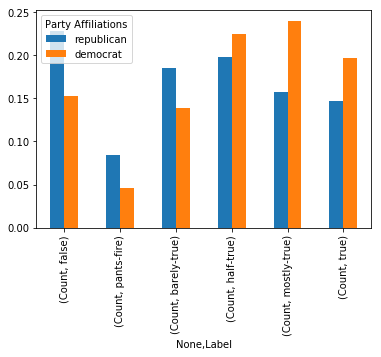

In [38]:
normalized_col_subject.plot(kind='bar')

# TEST

In [14]:
from wordcloud import WordCloud

# Read the whole text.
text = open('res/test_plain_text.txt').read()

In [37]:
text = BeautifulSoup(get_additional_info("1123.json")['statement'], 'html.parser').prettify()

In [38]:
text

'<p>\n Health care reform legislation is “likely to mandate free ‘sex change’ surgeries.”\n</p>'

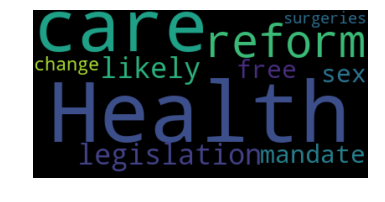

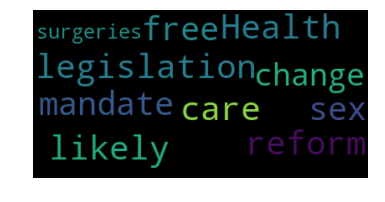

In [39]:
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

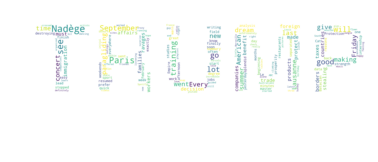

<Figure size 432x288 with 0 Axes>

In [23]:
text = open('res/test_plain_text.txt').read()
#text = BeautifulSoup(get_additional_info("1123.json")['statement'], 'html.parser').prettify()
# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
trump_mask = np.array(Image.open('res/Trumpy3.png'))
wc = WordCloud(background_color="white", max_words=2000, mask=trump_mask,contour_width=0, contour_color='steelblue')

# generate word cloud
wc.generate(text)

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.show()

In [24]:
#https://matplotlib.org/gallery/images_contours_and_fields/image_clip_path.html#sphx-glr-gallery-images-contours-and-fields-image-clip-path-py
#https://www.politifact.com//api/v/2/statement/1123/?format=json